In [1]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from functools import reduce
from tqdm import tqdm
from os import cpu_count

In [2]:
opus = pd.read_pickle("../data/raw/opus_sentences.pkl")
print(opus.shape)
opus.head()

(108017, 3)


,file,order,text
0,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,0,Source: librosgratis.liblit.com/
1,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,1,LAS AVENTURAS DE SHERLOCK HOLMES
2,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,2,Arthur Conan Doyle
3,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,3,1.
4,Doyle_Arthur_Conan-Adventures_of_Sherlock_Holm...,4,Escándalo en Bohemia


In [3]:
vocabulary = set("".join(opus["text"].to_list()))

In [4]:
char_to_ix = {k:i for i, k in enumerate(vocabulary, 3)}
char_to_ix["<pad>"] = 0
char_to_ix["<bos>"] = 1
char_to_ix["<eos>"] = 2
len(char_to_ix)

136

In [5]:
ix_to_char = {char_to_ix[k]:k for k in char_to_ix.keys()}

# generate training data

In [6]:
def text_to_ix(text):
    return [1] + [char_to_ix[c] for c in text] + [2]

In [7]:
def ix_to_text(ixs):
    return "".join([ix_to_char[i] for i in ixs])

In [8]:
letters = list(sorted(vocabulary))

def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0,1,1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0,1,1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i+1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                #print(char_to_ix[random_letter])
                noisy_sentence.append(random_letter)
                #noisy_sentence.append(char_to_ix[random_letter])
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass     
        i += 1
    #return noisy_sentence
    return "".join(noisy_sentence)

noise_maker("Relocate, remove, or add characters to create spelling mistakes", 0.97)

'Rleocate, remove, or add chaarcters to create spelling mistakes'

In [9]:
from timeit import default_timer

In [10]:
opus["text"].map(len).describe(percentiles = np.arange(0, 1, 0.1))

count    108017.000000
mean        108.709648
std          98.915442
min           1.000000
0%            1.000000
10%          22.000000
20%          35.000000
30%          49.000000
40%          65.000000
50%          83.000000
60%         103.000000
70%         129.000000
80%         163.000000
90%         222.000000
max        2249.000000
Name: text, dtype: float64

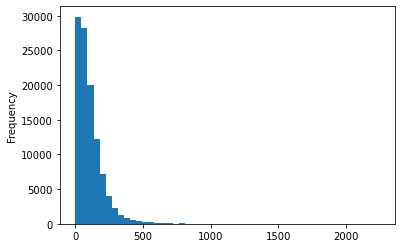

In [11]:
opus["text"].map(len).plot.hist(bins = 50)

In [12]:
def generate_noisy_examples(x, threshold = 0.95, noise_examples = 5):
    return (x, [x] * noise_examples + [noise_maker(x, threshold) for i in range(noise_examples)])

generate_noisy_examples(opus["text"][0])

('Source: librosgratis.liblit.com/',
 ['Source: librosgratis.liblit.com/',
  'Source: librosgratis.liblit.com/',
  'Source: librosgratis.liblit.com/',
  'Source: librosgratis.liblit.com/',
  'Source: librosgratis.liblit.com/',
  'Source: librsgratis.liblit.com/',
  'Source: librosgratis.liblit.com/',
  'urce: librsogrtis.liblit.com/',
  'Source: librosgartis.liblit.com/',
  'Source: librosgratis.liblitc.om/'])

In [13]:
p = Pool(cpu_count() - 1)

In [14]:
noisy_sentences = pd.DataFrame(p.imap_unordered(generate_noisy_examples, tqdm(opus["text"].to_list())), 
                               columns = ["text", "noise"])
# noisy_sentences = pd.DataFrame(p.imap_unordered(generate_noisy_examples, tqdm(opus["text"].head().to_list())), 
#                                columns = ["text", "noise"])

print(noisy_sentences.shape)
noisy_sentences.head()

100%|██████████| 108017/108017 [04:45<00:00, 378.41it/s]


(108017, 2)


,text,noise
0,LAS AVENTURAS DE SHERLOCK HOLMES,"[LAS AVENTURAS DE SHERLOCK HOLMES, LAS AVENTUR..."
1,1.,"[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]"
2,Source: librosgratis.liblit.com/,"[Source: librosgratis.liblit.com/, Source: lib..."
3,Escándalo en Bohemia,"[Escándalo en Bohemia, Escándalo en Bohemia, E..."
4,Arthur Conan Doyle,"[Arthur Conan Doyle, Arthur Conan Doyle, Arthu..."


In [15]:
noisy_sentences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108017 entries, 0 to 108016
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    108017 non-null  object
 1   noise   108017 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [16]:
noisy_opus = noisy_sentences.explode("noise")\
.reset_index(drop = True)

noisy_opus.head()

,text,noise
0,LAS AVENTURAS DE SHERLOCK HOLMES,LAS AVENTURAS DE SHERLOCK HOLMES
1,LAS AVENTURAS DE SHERLOCK HOLMES,LAS AVENTURAS DE SHERLOCK HOLMES
2,LAS AVENTURAS DE SHERLOCK HOLMES,LAS AVENTURAS DE SHERLOCK HOLMES
3,LAS AVENTURAS DE SHERLOCK HOLMES,LAS AVENTURAS DE SHERLOCK HOLMES
4,LAS AVENTURAS DE SHERLOCK HOLMES,LAS AVENTURAS DE SHERLOCK HOLMES


In [17]:
noisy_opus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080170 entries, 0 to 1080169
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1080170 non-null  object
 1   noise   1080170 non-null  object
dtypes: object(2)
memory usage: 16.5+ MB


In [18]:
X = list(p.imap_unordered(text_to_ix, tqdm(noisy_opus["noise"].to_list())))

100%|██████████| 1080170/1080170 [01:26<00:00, 12448.74it/s]


In [19]:
Y = list(p.imap_unordered(text_to_ix, tqdm(noisy_opus["text"].to_list())))

100%|██████████| 1080170/1080170 [01:27<00:00, 12313.15it/s]


In [20]:
noisy_opus = noisy_opus.assign(X = X, Y = Y)

print(noisy_opus.shape)
noisy_opus.head()

(1080170, 4)


,text,noise,X,Y
0,LAS AVENTURAS DE SHERLOCK HOLMES,LAS AVENTURAS DE SHERLOCK HOLMES,"[1, 99, 11, 122, 108, 11, 113, 17, 114, 95, 49...","[1, 99, 11, 122, 108, 11, 113, 17, 114, 95, 49..."
1,LAS AVENTURAS DE SHERLOCK HOLMES,LAS AVENTURAS DE SHERLOCK HOLMES,"[1, 99, 11, 122, 108, 11, 113, 17, 114, 95, 49...","[1, 99, 11, 122, 108, 11, 113, 17, 114, 95, 49..."
2,LAS AVENTURAS DE SHERLOCK HOLMES,LAS AVENTURAS DE SHERLOCK HOLMES,"[1, 99, 11, 122, 108, 11, 113, 17, 114, 95, 49...","[1, 99, 11, 122, 108, 11, 113, 17, 114, 95, 49..."
3,LAS AVENTURAS DE SHERLOCK HOLMES,LAS AVENTURAS DE SHERLOCK HOLMES,"[1, 99, 11, 122, 108, 11, 113, 17, 114, 95, 49...","[1, 99, 11, 122, 108, 11, 113, 17, 114, 95, 49..."
4,LAS AVENTURAS DE SHERLOCK HOLMES,LAS AVENTURAS DE SHERLOCK HOLMES,"[1, 99, 11, 122, 108, 11, 113, 17, 114, 95, 49...","[1, 99, 11, 122, 108, 11, 113, 17, 114, 95, 49..."


In [21]:
noisy_opus.to_pickle("../data/tidy/noisy_opus.pkl")

In [22]:
noisy_opus.sample(n = 100).to_pickle("../data/tidy/noisy_opus_sample.pkl")